## MoCo Demo: CIFAR-10

This is a simple demo for training MoCo on CIFAR-10. It can be run directly in a Colab notebook using a publicly available GPU.

#### Results

These are the ResNet-18 classification accuracy of a **kNN monitor** on the unsupervised pre-training features. 

| config | 200ep | 400ep | 800ep |
| --- | --- | --- | --- |
| Asymmetric | 82.6 | 86.3 | 88.7 |
| Symmetric | 85.3 | 88.5 | 89.7 |

#### Notes

* **Symmetric loss**: the original MoCo paper uses an *asymmetric* loss -- one crop is the query and the other crop is the key, and it backpropagates to one crop (query). Following SimCLR/BYOL, here we provide an option of a *symmetric* loss -- it swaps the two crops and computes an extra loss. The symmetric loss behaves like 2x epochs of the asymmetric counterpart: this may dominate the comparison results when the models are trained with a fixed epoch number.

* **SplitBatchNorm**: the original MoCo was trained in 8 GPUs. To simulate the multi-GPU behavior of BatchNorm in this 1-GPU demo, we provide a SplitBatchNorm layer. We set `--bn-splits 8` by default to simulate 8 GPUs. `--bn-splits 1` is analogous to SyncBatchNorm in the multi-GPU case.

* **kNN monitor**: this demo provides a kNN monitor on the test set. Training a linear classifier on frozen features often achieves higher accuracy. To train a linear classifier (not provided in this demo), we recommend using lr=30, wd=0, epochs=100 with a stepwise or cosine schedule. The ResNet-18 model (kNN 89.7) has 90.7 linear classification accuracy.

#### Disclaimer

This demo aims to provide an interface with a free GPU (thanks to Colab) for understanding how the code runs. We suggest users be careful to draw conclusions from CIFAR, which may not generalize beyond this dataset. We have verified that it is beneficial to have the momentum encoder (disabling it by `--moco-m 0.0` should fail), queue size (saturated at `--moco-k 4096`) and ShuffleBN (without which loses 4% at 800 epochs) on CIFAR, similar to the observations on ImageNet. But new observations made only on CIFAR should be judged with caution.

#### References
This demo is adapted from:
* http://github.com/zhirongw/lemniscate.pytorch
* https://github.com/leftthomas/SimCLR








### Prepare

Check GPU settings. A free GPU in Colab is <= Tesla P100. The log of the demo is based on a Tesla V100 from Google Cloud Platform.


In [ ]:
gpu_info = !nvidia-smi -i 0
gpu_info = '\n'.join(gpu_info)
print(gpu_info)
from datetime import datetime
from functools import partial
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet
from tqdm import tqdm
import argparse
import json
import math
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/My Drive')

Tue Dec 29 02:29:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W /  70W |   1227MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Set arguments

In [ ]:
# set command line arguments here when running in ipynb
batch_size = 256
lr = 0.03
epochs = 800
cos = False
wd = 5e-4

moco_dim = 128
moco_k = 4096
moco_m = 0.99
moco_t = 0.1
bn_splits = 8

knn_k = 200
knn_t = 0.1


schedule = [160, 240, 320] 
symmetric = False
results_dir = './drive/My Drive'
if results_dir == '':
    results_dir = './cache-' + datetime.now().strftime("%Y-%m-%d-%H-%M-%S-moco")


### Define data loaders

In [ ]:
class CIFAR10Pair(CIFAR10):
    """CIFAR10 Dataset.
    """
    def __getitem__(self, index):
        img = self.data[index]
        img = Image.fromarray(img)
        to_tensor = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])
        if self.transform is not None:
            im_1 = self.transform(img)
            im_2 = self.transform(img)
        img = to_tensor(img)

        return im_1, im_2, img

import random
from PIL import ImageFilter
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

# data prepare
train_data = CIFAR10Pair(root='data', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

memory_data = CIFAR10(root='data', train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

test_data = CIFAR10(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


### Define base encoder

In [ ]:
class Interpolate(nn.Module):
    """nn.Module wrapper for F.interpolate"""

    def __init__(self, size=None, scale_factor=None):
        super().__init__()
        self.size, self.scale_factor = size, scale_factor

    def forward(self, x):
        return nn.functional.interpolate(x, size=self.size, scale_factor=self.scale_factor)

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )


def resize_conv3x3(in_planes, out_planes, scale=1):
    """upsample + 3x3 convolution with padding to avoid checkerboard artifact"""
    if scale == 1:
        return conv3x3(in_planes, out_planes)
    else:
        return nn.Sequential(
            Interpolate(scale_factor=scale), conv3x3(in_planes, out_planes)
        )

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def resize_conv1x1(in_planes, out_planes, scale=1):
    """upsample + 1x1 convolution with padding to avoid checkerboard artifact"""
    if scale == 1:
        return conv1x1(in_planes, out_planes)
    else:
        return nn.Sequential(
            Interpolate(scale_factor=scale), conv1x1(in_planes, out_planes)
        )
       
class DecoderBlock(nn.Module):
    """
    ResNet block, but convs replaced with resize convs, and channel increase is in
    second conv, not first
    """

    expansion = 1

    def __init__(self, inplanes, planes, scale=1, upsample=None):
        super().__init__()
        self.conv1 = resize_conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = resize_conv3x3(inplanes, planes, scale)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsample = upsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        out = self.relu(out)

        return out

class DecoderBottleneck(nn.Module):
    """
    ResNet bottleneck, but convs replaced with resize convs
    """

    expansion = 4

    def __init__(self, inplanes, planes, scale=1, upsample=None):
        super().__init__()
        width = planes  # this needs to change if we want wide resnets
        self.conv1 = resize_conv1x1(inplanes, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = resize_conv3x3(width, width, scale)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.upsample = upsample
        self.scale = scale

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNetDecoder(nn.Module):
    """
    Resnet in reverse order
    """

    def __init__(self, block, layers, latent_dim, input_height, first_conv=False, maxpool1=False):
        super().__init__()

        self.expansion = block.expansion
        self.inplanes = 512 * block.expansion
        self.first_conv = first_conv
        self.maxpool1 = maxpool1
        self.input_height = input_height

        self.upscale_factor = 8

        self.linear = nn.Linear(latent_dim, self.inplanes * 4 * 4)

        self.layer1 = self._make_layer(block, 256, layers[0], scale=2)
        self.layer2 = self._make_layer(block, 128, layers[1], scale=2)
        self.layer3 = self._make_layer(block, 64, layers[2], scale=2)

        if self.maxpool1:
            self.layer4 = self._make_layer(block, 64, layers[3], scale=2)
            self.upscale_factor *= 2
        else:
            self.layer4 = self._make_layer(block, 64, layers[3])

        if self.first_conv:
            self.upscale = Interpolate(scale_factor=2)
            self.upscale_factor *= 2
        else:
            self.upscale = Interpolate(scale_factor=1)

        # interpolate after linear layer using scale factor
        self.upscale1 = Interpolate(size=input_height // self.upscale_factor)

        self.conv1 = nn.Conv2d(
            64 * block.expansion, 3, kernel_size=3, stride=1, padding=1, bias=False
        )

    def _make_layer(self, block, planes, blocks, scale=1):
        upsample = None
        if scale != 1 or self.inplanes != planes * block.expansion:
            upsample = nn.Sequential(
                resize_conv1x1(self.inplanes, planes * block.expansion, scale),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, scale, upsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.linear(x)

        # NOTE: replaced this by Linear(in_channels, 514 * 4 * 4)
        # x = F.interpolate(x, scale_factor=4)

        x = x.view(x.size(0), 512 * self.expansion, 4, 4)
        x = self.upscale1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.upscale(x)

        x = self.conv1(x)
        return x
        
def resnet18_decoder(latent_dim, input_height, first_conv=False, maxpool1=False):
    return ResNetDecoder(DecoderBlock, [2, 2, 2, 2], latent_dim, input_height, first_conv, maxpool1)

In [ ]:
# SplitBatchNorm: simulate multi-gpu behavior of BatchNorm in one gpu by splitting alone the batch dimension
# implementation adapted from https://github.com/davidcpage/cifar10-fast/blob/master/torch_backend.py
class SplitBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            running_mean_split = self.running_mean.repeat(self.num_splits)
            running_var_split = self.running_var.repeat(self.num_splits)
            outcome = nn.functional.batch_norm(
                input.view(-1, C * self.num_splits, H, W), running_mean_split, running_var_split, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
            self.running_mean.data.copy_(running_mean_split.view(self.num_splits, C).mean(dim=0))
            self.running_var.data.copy_(running_var_split.view(self.num_splits, C).mean(dim=0))
            return outcome
        else:
            return nn.functional.batch_norm(
                input, self.running_mean, self.running_var, 
                self.weight, self.bias, False, self.momentum, self.eps)

class ModelBase(nn.Module):
    """
    Common CIFAR ResNet recipe.
    Comparing with ImageNet ResNet recipe, it:
    (i) replaces conv1 with kernel=3, str=1
    (ii) removes pool1
    """
    def __init__(self, feature_dim=128, arch=None, bn_splits=16):
        super(ModelBase, self).__init__()

        # use split batchnorm
        norm_layer = partial(SplitBatchNorm, num_splits=bn_splits) if bn_splits > 1 else nn.BatchNorm2d
        # get specified resnet model
        resnet_arch = getattr(resnet, arch)
        net = resnet_arch(num_classes=feature_dim, norm_layer=norm_layer)

        # make changes to original resnet
        self.net = []
        for name, module in net.named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if isinstance(module, nn.MaxPool2d):
                continue
            if isinstance(module, nn.Linear):
                self.net.append(nn.Flatten(1))
                module = nn.Sequential(nn.Flatten(1), nn.Linear(512, 512),  nn.ReLU(), module)
            self.net.append(module)

        # build net
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        x = self.net(x)
        # note: not normalized here
        return x

### Define MoCo wrapper

In [ ]:
class ModelMoCo(nn.Module):
    def __init__(self, dim=128, K=4096, m=0.99, alpha=0.5, T=0.1, arch='resnet18', bn_splits=8, symmetric=False):
        super(ModelMoCo, self).__init__()
        self.alpha = alpha
        self.K = K # number of keys
        self.m = m # momentum update param
        self.T = T # temperature hyperparameter to control randomness of preds
        self.symmetric = symmetric
        
        # create the encoders
        self.encoder_q = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits) # query encoder
        self.encoder_k = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits) # dictionary key encoder
        
        self.decoder = resnet18_decoder(512, 32).cuda()

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient, update by EMA of k

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.t()  # transpose
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle_single_gpu(self, x):
        """
        Batch shuffle, for making use of BatchNorm.
        """
        # random shuffle index
        idx_shuffle = torch.randperm(x.shape[0]).cuda()

        # index for restoring
        idx_unshuffle = torch.argsort(idx_shuffle)

        return x[idx_shuffle], idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle_single_gpu(self, x, idx_unshuffle):
        """
        Undo batch shuffle.
        """
        return x[idx_unshuffle]


    def mse_loss(self, im_q, img):
        encoder = nn.Sequential(*list(self.encoder_q.children())[0][:-1])
        q = encoder(im_q)
        q = torch.flatten(q, 1)
        out = self.decoder(q)
        loss = nn.MSELoss().cuda()(img, out)

        return loss, out        

    def contrastive_loss(self, im_q, im_k):
        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)  # already normalized

        # compute key features
        with torch.no_grad():  # no gradient to keys
            # shuffle for making use of BN
            im_k_, idx_unshuffle = self._batch_shuffle_single_gpu(im_k)

            k = self.encoder_k(im_k_)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)  # already normalized

            # undo shuffle
            k = self._batch_unshuffle_single_gpu(k, idx_unshuffle)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
        
        loss = nn.CrossEntropyLoss().cuda()(logits, labels)

        return loss, q, k

    def forward(self, im1, im2, img):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            loss
        """

        # update the key encoder
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()

        # compute loss
        if self.symmetric:  # asymmetric loss
            loss_12, q1, k2 = self.contrastive_loss(im1, im2)
            loss_21, q2, k1 = self.contrastive_loss(im2, im1)
            loss = loss_12 + loss_21
            k = torch.cat([k1, k2], dim=0)
        else:  # asymmetric loss
            contrastive_loss, q, k = self.contrastive_loss(im1, im2)
            mse_loss, _ = self.mse_loss(im1, img)
            loss = mse_loss * (1- self.alpha) + contrastive_loss * self.alpha
        self._dequeue_and_enqueue(k)

        return loss, mse_loss, contrastive_loss

# create model


#print(model.encoder_q)

### Define train/test



In [ ]:
# train for one epoch
def train(net, data_loader, train_optimizer, epoch):
    net.train()
    adjust_learning_rate(optimizer, epoch)
    total_mse, total_contrastive = 0, 0
    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader, position = 0, leave = True)
    for im_1, im_2, img in train_bar:
        im_1, im_2, img = im_1.cuda(non_blocking=True), im_2.cuda(non_blocking=True), img.cuda(non_blocking=True)

        loss, mse, contrastive = net(im_1, im_2, img)
        
        train_optimizer.zero_grad()

        loss.backward()

        train_optimizer.step()

        total_num += data_loader.batch_size
        total_loss += loss.item() * data_loader.batch_size
        total_mse += mse.item() * data_loader.batch_size
        total_contrastive += contrastive.item() * data_loader.batch_size
        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}, MSE: {:.4f}, Contrastive: {:.4f}'.format(epoch, epochs, optimizer.param_groups[0]['lr'], total_loss / total_num, total_mse/total_num, total_contrastive/total_num))

    return total_loss / total_num

# lr scheduler for training
def adjust_learning_rate(optimizer, epoch):
    """Decay the learning rate based on schedule"""
    global lr
    global cos
    if cos:  # cosine lr schedule
        lr *= 0.5 * (1. + math.cos(math.pi * epoch / epochs))
    else:  # stepwise lr schedule
        for milestone in  schedule:
            lr *= 0.1 if epoch == milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# test using a knn monitor
def test(net, memory_data_loader, test_data_loader, epoch):
    global epochs
    net.eval()
    classes = len(memory_data_loader.dataset.classes)
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, target in tqdm(memory_data_loader, desc='Feature extracting', position = 0, leave = True):
            feature = net(data.cuda(non_blocking=True))
            feature = F.normalize(feature, dim=1)
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader, position = 0, leave = True)
        for data, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature = net(data)
            feature = F.normalize(feature, dim=1)
            
            pred_labels = knn_predict(feature, feature_bank, feature_labels, classes,  knn_k, knn_t)

            total_num += data.size(0)
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}%'.format(epoch, epochs, total_top1 / total_num * 100))

    return total_top1 / total_num * 100

# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
    sim_weight = (sim_weight / knn_t).exp()

    # counts for each class
    one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
    # weighted score ---> [B, C]
    pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels

In [ ]:
print(model.encoder_q)

In [ ]:


model = ModelMoCo(
        dim=moco_dim,
        K=moco_k,
        m=moco_m,
        T=moco_t,
        arch = 'resnet18',
        alpha = 0.7,
        bn_splits=bn_splits,
        symmetric=symmetric,
    ).cuda()

# define optimizer

lr = 0.003
schedule = [120, 220, 400]
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, nesterov = True, momentum=0.9)


# load model if resume
resume = './drive/My Drive/moco_v2_with_AE_SGD_mlp_alpha0.40.pth'

if resume is not '':
    checkpoint = torch.load(resume)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start = checkpoint['epoch'] + 1
    print('Loaded from: {}'.format(resume))

Loaded from: ./drive/My Drive/moco_v2_with_AE_SGD_mlp_alpha0.40.pth


### Start training

In [ ]:
torch.cuda.empty_cache() 

In [ ]:
# logging

#epoch_start = 1

# training loop
for epoch in range(epoch_start, 200):
    train_loss = train(model, train_loader, optimizer, epoch)
    test_acc_1 = test(model.encoder_q, memory_loader, test_loader, epoch)
    # save statistics
    # save model
    torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),},  results_dir + '/moco_v2_with_AE_alpha0.70.pth')

In [ ]:
while True:pass

In [ ]:
import tensorflow as tf
import numpy as np

(cifar_trainX, cifar_trainY), (cifar_testX, cifar_testY) = tf.keras.datasets.cifar10.load_data()
cifar_trainX = cifar_trainX.astype("float32") / 255.0
cifar_testX = cifar_testX.astype("float32") / 255.0
trainY = tf.keras.utils.to_categorical(cifar_trainY)
testY = tf.keras.utils.to_categorical(cifar_testY)
train_x = np.transpose(cifar_trainX, (0, 3, 1, 2))
train_x = torch.from_numpy(train_x)

train_x.cuda()

print('done')

170500096/170498071 [==============================] - 2s 0us/step
done


In [ ]:
print(model.encoder_q)

(2000, 128)


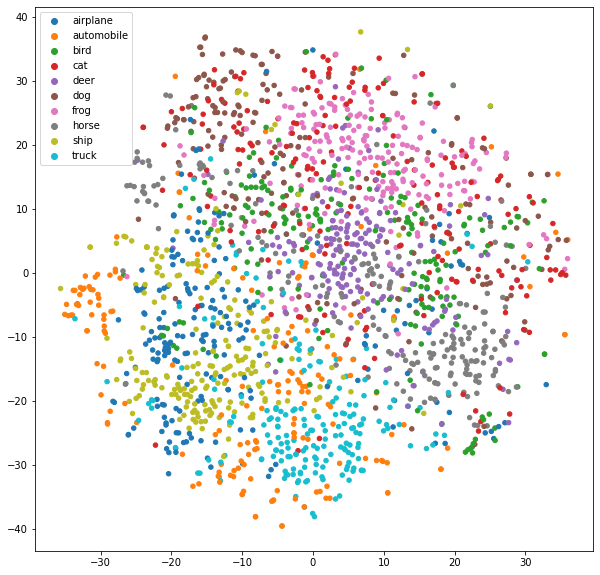

In [ ]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn import manifold

#encoded_test_imgs = resnet(test_x[:1000].cuda()).detach().cpu().numpy()
#generate tsne projection
x = model.encoder_q(train_x[4000:6000].cuda())
x = np.squeeze(x.detach().cpu().numpy())
print(x.shape)
%matplotlib inline

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

#encoded_test_imgs = resnet(test_x[:1000].cuda()).detach().cpu().numpy()
#generate tsne projection

tsne = manifold.TSNE(n_components=2, init='pca', random_state=13, perplexity=50)
X_tsne = tsne.fit_transform(x)

fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1],	c=cifar_trainY[4000:6000], s=20, cmap='tab10')

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.show() 

Linear Eval


In [ ]:
aug, _, img = iter(train_loader).next()[:10]

_ , z = model.mse_loss(aug.cuda(), img.cuda())

aug = np.transpose(aug.cpu().detach().numpy(), (0, 2, 3, 1))
img = np.transpose(img.cpu().detach().numpy(), (0, 2, 3, 1))
z = np.transpose(z.cpu().detach().numpy(), (0, 2, 3, 1))


%matplotlib inline
iter_num=10
fig = plt.figure(figsize=(60,500), constrained_layout=True)

for i in range(1,iter_num):
  ax1 = fig.add_subplot(34,50,i)
  ax1.set_axis_off()
  ax1.set_xticklabels([])
  ax1.set_yticklabels([])
  ax1.set_aspect('equal')
  
  ax1.imshow(z[i-1])

for i in range(1,iter_num):
  ax2 = fig.add_subplot(40,50,i)
  ax2.set_axis_off()
  ax2.set_xticklabels([])
  ax2.set_yticklabels([])
  ax2.set_aspect('equal')
  #prediction = autoencoder.decoder.predict(np.array([z[i].tolist()]))
  ax2.imshow(aug[i-1]) 

for i in range(1,iter_num):
  ax2 = fig.add_subplot(50,50,i)
  ax2.set_axis_off()
  ax2.set_xticklabels([])
  ax2.set_yticklabels([])
  ax2.set_aspect('equal')
  #prediction = autoencoder.decoder.predict(np.array([z[i].tolist()]))
  ax2.imshow(img[i-1])

plt.subplots_adjust(wspace=None, hspace=None)
plt.show()


In [ ]:
print(model.encoder_q)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision

for param in model.encoder_q.parameters():
  param.requires_grad = False

new_model = nn.Sequential(*list(model.encoder_q.children())[0][:-1])

#print(new_model)

for param in new_model:
  param.requires_grad = False

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc = nn.Linear(512, 10)

  def forward(self, x):
    out = new_model(x)
    #out = nn.Flatten(1)(out)
    out = self.fc(out)

    return out
        
net = Net()
net.cuda()

lr = 3e-3
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = 1e-5)

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])
data_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(data_set, batch_size=128,
                                          shuffle=True, num_workers=16, pin_memory = True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128,
                                          shuffle=False, num_workers=16, pin_memory = True)



def train_val(net, data_loader, train_optimizer):
    global lr
    schedule = [40, 60]
    criterion = nn.CrossEntropyLoss().cuda()
    is_train = train_optimizer is not None
    net.train() if is_train else net.eval()

    total_loss, total_correct_1, total_correct_3, total_num, data_bar = 0.0, 0.0, 0.0, 0, tqdm(data_loader, position=0, leave=True)
    with (torch.enable_grad() if is_train else torch.no_grad()):
        for data, target in data_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            out = net(data)
            loss = criterion(out, target)

            if is_train:
                train_optimizer.zero_grad()
                loss.backward()
                train_optimizer.step()




            total_num += data.size(0)
            total_loss += loss.item() * data.size(0)
            prediction = torch.argsort(out, dim=-1, descending=True)
            total_correct_1 += torch.sum((prediction[:, 0:1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_correct_3 += torch.sum((prediction[:, 0:3] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()

            data_bar.set_description('{} Epoch: [{}/{}] lr: {:.4f} Loss: {:.4f} ACC@1: {:.2f}% ACC@5: {:.2f}%'
                                     .format('Train' if is_train else 'Test', epoch, epochs,lr, total_loss / total_num,
                                             total_correct_1 / total_num * 100, total_correct_3 / total_num * 100))
    if is_train:    
      if schedule is not None:
        for milestone in schedule:
            lr *= 0.1 if epoch == milestone else 1.
        for param_group in train_optimizer.param_groups:
            param_group['lr'] = lr

    return total_loss / total_num, total_correct_1 / total_num * 100, total_correct_3 / total_num * 100



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
epochs = 100
for epoch in range(8, epochs+1):
  train_loss, train_acc_1, train_acc_3 = train_val(net, data_loader, optimizer)
  test_loss, test_acc_1, test_acc_3 = train_val(net, test_loader, None)


Train Epoch: [8/100] lr: 0.0030 Loss: 1.2228 ACC@1: 58.90% ACC@5: 85.42%: 100%|██████████| 391/391 [00:16<00:00, 24.34it/s]
Test Epoch: [8/100] lr: 0.0030 Loss: 1.0681 ACC@1: 62.95% ACC@5: 87.84%: 100%|██████████| 79/79 [00:04<00:00, 17.77it/s]
Train Epoch: [9/100] lr: 0.0030 Loss: 0.9890 ACC@1: 65.94% ACC@5: 89.98%: 100%|██████████| 391/391 [00:15<00:00, 24.46it/s]
Test Epoch: [9/100] lr: 0.0030 Loss: 0.9681 ACC@1: 66.07% ACC@5: 90.61%: 100%|██████████| 79/79 [00:04<00:00, 17.64it/s]
Train Epoch: [10/100] lr: 0.0030 Loss: 0.9522 ACC@1: 66.81% ACC@5: 90.74%: 100%|██████████| 391/391 [00:16<00:00, 24.28it/s]
Test Epoch: [10/100] lr: 0.0030 Loss: 0.9424 ACC@1: 66.87% ACC@5: 90.99%: 100%|██████████| 79/79 [00:04<00:00, 17.24it/s]
Train Epoch: [11/100] lr: 0.0030 Loss: 0.9304 ACC@1: 67.72% ACC@5: 90.97%: 100%|██████████| 391/391 [00:16<00:00, 24.42it/s]
Test Epoch: [11/100] lr: 0.0030 Loss: 0.9270 ACC@1: 67.22% ACC@5: 91.31%: 100%|██████████| 79/79 [00:04<00:00, 17.45it/s]
Train Epoch: [12

# 4000 label benchmark

In [ ]:
resume = './drive/My Drive/moco_v2_with_AE_SGD_mlp_alpha0.50.pth'

if resume is not '':
    checkpoint = torch.load(resume)
    model.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start = checkpoint['epoch'] + 1
    print('Loaded from: {}'.format(resume))

Loaded from: ./drive/My Drive/moco_v2_with_AE_SGD_mlp_alpha0.50.pth


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision
import numpy as np


new_model = nn.Sequential(*list(model.encoder_q.children())[0][:-1])

for param in new_model:
  param.requires_grad = False

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc = nn.Linear(512, 10)
  def forward(self, x):
    out = new_model(x)
    out = nn.Flatten(1)(out)
    out = self.fc(out)

    return out
        
net = Net()
net.cuda()

lr = 3e-3
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = 1e-5)

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=False, num_workers=4, pin_memory = True)

def get_indices(dataset, num_classes):
  indices = []
  for Class in range(10):
    for j in range(num_classes):
      x = np.random.randint(0, 50000)
      while dataset.targets[x] != Class:
        x = np.random.randint(0, 50000)
      indices.append(x)
  return indices


def train_val(net, data_loader, train_optimizer):
    global lr
    schedule = [20, 40]
    criterion = nn.CrossEntropyLoss().cuda()
    is_train = train_optimizer is not None
    net.train() if is_train else net.eval()

    total_loss, total_correct_1, total_correct_3, total_num, data_bar = 0.0, 0.0, 0.0, 0, tqdm(data_loader, position=0, leave=True)
    with (torch.enable_grad() if is_train else torch.no_grad()):
        for data, target in data_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            out = net(data)
            loss = criterion(out, target)

            if is_train:
                train_optimizer.zero_grad()
                loss.backward()
                train_optimizer.step()


            total_num += data.size(0)
            total_loss += loss.item() * data.size(0)
            prediction = torch.argsort(out, dim=-1, descending=True)
            total_correct_1 += torch.sum((prediction[:, 0:1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_correct_3 += torch.sum((prediction[:, 0:3] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()

            data_bar.set_description('{} Epoch: [{}/{}] lr: {:.4f} Loss: {:.4f} ACC@1: {:.2f}% ACC@5: {:.2f}%'
                                     .format('Train' if is_train else 'Test', epoch, epochs, lr, total_loss / total_num,
                                             total_correct_1 / total_num * 100, total_correct_3 / total_num * 100))
            
    if is_train:
      if schedule is not None:
        for milestone in schedule:
            lr *= 0.1 if epoch == milestone else 1.
        for param_group in train_optimizer.param_groups:
            param_group['lr'] = lr

    return total_correct_1 / total_num * 100



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import numpy as np

train_acc = []
test_acc = []
for i in range(5):
  print(f"Random Seed: {i}")
  best_train = 0
  best_test = 0
  np.random.seed(i)

  indices = get_indices(dataset, 100)
  sampler = torch.utils.data.SubsetRandomSampler(indices)

  train_loader = DataLoader(dataset, batch_size=64, sampler = sampler , num_workers=16, pin_memory=True)

  new_model = nn.Sequential(*list(model.encoder_q.children())[0][:-1])

  for param in new_model.parameters():
    param.requires_grad = False

  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
      self.fc = nn.Linear(512, 10)

    def forward(self, x):
      out = new_model(x)
      out = nn.Flatten(1)(out)
      out = self.fc(out)

      return out
          
  net = Net()
  net.cuda()

  lr = 3e-3
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = 1e-5)

  epoch_start = 1
  epochs = 100
  for epoch in range(epoch_start, epochs+1):
    acc1 = train_val(net, train_loader, optimizer)
    acc2 = train_val(net, test_loader, None)
    if acc1 > best_train:
      best_train = acc1
    if acc2 > best_test:
      best_test = acc2
  train_acc.append(acc1)
  test_acc.append(acc2)

print(train_acc)
print(test_acc)

train_acc = np.array(train_acc)
test_acc = np.array(test_acc)
print(np.mean(train_acc))
print(np.mean(test_acc))
print(np.std(train_acc))
print(np.std(test_acc))


  0%|          | 0/16 [00:00<?, ?it/s]

Random Seed: 0


Train Epoch: [1/100] lr: 0.0030 Loss: 2.2435 ACC@1: 19.20% ACC@5: 45.00%: 100%|██████████| 16/16 [00:01<00:00, 11.16it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.9985 ACC@1: 29.22% ACC@5: 64.77%: 100%|██████████| 157/157 [00:04<00:00, 38.12it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.8975 ACC@1: 37.20% ACC@5: 70.50%: 100%|██████████| 16/16 [00:01<00:00, 11.76it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.8097 ACC@1: 37.74% ACC@5: 69.50%: 100%|██████████| 157/157 [00:04<00:00, 37.64it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.6656 ACC@1: 51.40% ACC@5: 78.80%: 100%|██████████| 16/16 [00:01<00:00, 11.85it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.6169 ACC@1: 48.33% ACC@5: 79.38%: 100%|██████████| 157/157 [00:04<00:00, 38.34it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.5292 ACC@1: 54.80% ACC@5: 81.30%: 100%|██████████| 16/16 [00:01<00:00, 11.57it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.5431 ACC@1: 48.81% ACC@5: 79.26%: 100%|██████████| 157/157 [00:04<00:00, 38.41it/s]
Train Epoch: [5/100]

Random Seed: 1


Train Epoch: [1/100] lr: 0.0030 Loss: 2.2421 ACC@1: 18.40% ACC@5: 42.40%: 100%|██████████| 16/16 [00:01<00:00, 11.56it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 2.0295 ACC@1: 29.55% ACC@5: 55.48%: 100%|██████████| 157/157 [00:04<00:00, 37.91it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.8738 ACC@1: 41.30% ACC@5: 67.60%: 100%|██████████| 16/16 [00:01<00:00, 11.79it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.8061 ACC@1: 40.98% ACC@5: 70.64%: 100%|██████████| 157/157 [00:04<00:00, 37.90it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.6821 ACC@1: 45.80% ACC@5: 77.60%: 100%|██████████| 16/16 [00:01<00:00, 11.57it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.6314 ACC@1: 48.34% ACC@5: 78.33%: 100%|██████████| 157/157 [00:04<00:00, 37.69it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.5585 ACC@1: 48.60% ACC@5: 79.30%: 100%|██████████| 16/16 [00:01<00:00, 11.50it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.5556 ACC@1: 48.77% ACC@5: 79.73%: 100%|██████████| 157/157 [00:04<00:00, 37.56it/s]
Train Epoch: [5/100]

Random Seed: 2


Train Epoch: [1/100] lr: 0.0030 Loss: 2.2120 ACC@1: 16.40% ACC@5: 43.20%: 100%|██████████| 16/16 [00:01<00:00, 11.26it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 2.0246 ACC@1: 23.54% ACC@5: 59.27%: 100%|██████████| 157/157 [00:04<00:00, 37.38it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.8613 ACC@1: 38.90% ACC@5: 71.30%: 100%|██████████| 16/16 [00:01<00:00, 10.88it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.7490 ACC@1: 46.84% ACC@5: 75.72%: 100%|██████████| 157/157 [00:04<00:00, 37.62it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.6326 ACC@1: 48.80% ACC@5: 79.60%: 100%|██████████| 16/16 [00:01<00:00, 11.07it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.6319 ACC@1: 44.31% ACC@5: 78.21%: 100%|██████████| 157/157 [00:04<00:00, 37.45it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.4909 ACC@1: 52.20% ACC@5: 83.80%: 100%|██████████| 16/16 [00:01<00:00, 11.50it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.5411 ACC@1: 50.30% ACC@5: 79.40%: 100%|██████████| 157/157 [00:04<00:00, 37.61it/s]
Train Epoch: [5/100]

Random Seed: 3


Train Epoch: [1/100] lr: 0.0030 Loss: 2.2119 ACC@1: 20.20% ACC@5: 45.20%: 100%|██████████| 16/16 [00:01<00:00, 11.23it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.9820 ACC@1: 34.87% ACC@5: 66.38%: 100%|██████████| 157/157 [00:04<00:00, 37.85it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.8709 ACC@1: 37.20% ACC@5: 70.60%: 100%|██████████| 16/16 [00:01<00:00, 11.20it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.7467 ACC@1: 45.80% ACC@5: 75.92%: 100%|██████████| 157/157 [00:04<00:00, 36.46it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.6387 ACC@1: 51.00% ACC@5: 80.60%: 100%|██████████| 16/16 [00:01<00:00, 11.28it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.6382 ACC@1: 43.66% ACC@5: 77.67%: 100%|██████████| 157/157 [00:04<00:00, 36.80it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.5003 ACC@1: 51.90% ACC@5: 83.80%: 100%|██████████| 16/16 [00:01<00:00, 11.51it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.5366 ACC@1: 49.24% ACC@5: 79.99%: 100%|██████████| 157/157 [00:04<00:00, 38.09it/s]
Train Epoch: [5/100]

Random Seed: 4


Train Epoch: [1/100] lr: 0.0030 Loss: 2.2348 ACC@1: 19.70% ACC@5: 42.60%: 100%|██████████| 16/16 [00:01<00:00, 11.46it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.9844 ACC@1: 32.39% ACC@5: 64.91%: 100%|██████████| 157/157 [00:04<00:00, 37.70it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.8750 ACC@1: 35.90% ACC@5: 72.70%: 100%|██████████| 16/16 [00:01<00:00, 11.28it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.8173 ACC@1: 43.80% ACC@5: 70.48%: 100%|██████████| 157/157 [00:04<00:00, 37.82it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.6569 ACC@1: 49.30% ACC@5: 78.80%: 100%|██████████| 16/16 [00:01<00:00, 11.49it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.6193 ACC@1: 49.46% ACC@5: 79.62%: 100%|██████████| 157/157 [00:04<00:00, 37.83it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.5203 ACC@1: 51.90% ACC@5: 83.30%: 100%|██████████| 16/16 [00:01<00:00, 11.08it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.5134 ACC@1: 50.80% ACC@5: 81.36%: 100%|██████████| 157/157 [00:04<00:00, 37.61it/s]
Train Epoch: [5/100]

[69.6, 70.8, 71.1, 71.8, 67.80000000000001]
[60.33, 59.39, 59.9, 59.330000000000005, 58.9]
70.22
59.57000000000001
1.4034243834279017
0.49505555243830884


In [ ]:
import numpy as np

train_acc = []
test_acc = []
for i in range(5):
  print(f"Random Seed: {i}")
  best_train = 0
  best_test = 0
  np.random.seed(i)

  indices = get_indices(dataset, 200)
  sampler = torch.utils.data.SubsetRandomSampler(indices)

  train_loader = DataLoader(dataset, batch_size=64, sampler = sampler , num_workers=16, pin_memory=True)

  new_model = nn.Sequential(*list(model.encoder_q.children())[0][:-1])

  for param in new_model.parameters():
    param.requires_grad = False

  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
      self.fc = nn.Linear(512, 10)

    def forward(self, x):
      out = new_model(x)
      out = nn.Flatten(1)(out)
      out = self.fc(out)

      return out
          
  net = Net()
  net.cuda()

  lr = 3e-3
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = 1e-5)

  epoch_start = 1
  epochs = 100
  for epoch in range(epoch_start, epochs+1):
    acc1 = train_val(net, train_loader, optimizer)
    acc2 = train_val(net, test_loader, None)
    if acc1 > best_train:
      best_train = acc1
    if acc2 > best_test:
      best_test = acc2
  train_acc.append(acc1)
  test_acc.append(acc2)

print(train_acc)
print(test_acc)

train_acc = np.array(train_acc)
test_acc = np.array(test_acc)
print(np.mean(train_acc))
print(np.mean(test_acc))
print(np.std(train_acc))
print(np.std(test_acc))


  0%|          | 0/32 [00:00<?, ?it/s]

Random Seed: 0


Train Epoch: [1/100] lr: 0.0030 Loss: 2.0509 ACC@1: 29.15% ACC@5: 58.55%: 100%|██████████| 32/32 [00:01<00:00, 16.50it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.7413 ACC@1: 41.14% ACC@5: 77.73%: 100%|██████████| 157/157 [00:04<00:00, 37.35it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.5936 ACC@1: 49.35% ACC@5: 81.75%: 100%|██████████| 32/32 [00:01<00:00, 16.70it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.5115 ACC@1: 52.22% ACC@5: 81.43%: 100%|██████████| 157/157 [00:04<00:00, 37.50it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.4291 ACC@1: 54.35% ACC@5: 83.50%: 100%|██████████| 32/32 [00:01<00:00, 16.94it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.4144 ACC@1: 52.33% ACC@5: 82.59%: 100%|██████████| 157/157 [00:04<00:00, 37.46it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.3278 ACC@1: 58.25% ACC@5: 84.85%: 100%|██████████| 32/32 [00:01<00:00, 16.45it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.3285 ACC@1: 55.70% ACC@5: 83.73%: 100%|██████████| 157/157 [00:04<00:00, 37.08it/s]
Train Epoch: [5/100]

Random Seed: 1


Train Epoch: [1/100] lr: 0.0030 Loss: 1.9797 ACC@1: 33.20% ACC@5: 64.90%: 100%|██████████| 32/32 [00:01<00:00, 16.84it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.6689 ACC@1: 48.06% ACC@5: 80.06%: 100%|██████████| 157/157 [00:04<00:00, 37.65it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.5655 ACC@1: 49.35% ACC@5: 80.45%: 100%|██████████| 32/32 [00:01<00:00, 16.93it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.5357 ACC@1: 48.30% ACC@5: 77.63%: 100%|██████████| 157/157 [00:04<00:00, 37.79it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.3928 ACC@1: 54.45% ACC@5: 83.65%: 100%|██████████| 32/32 [00:01<00:00, 16.13it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.3646 ACC@1: 54.90% ACC@5: 84.01%: 100%|██████████| 157/157 [00:04<00:00, 37.05it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.3058 ACC@1: 55.85% ACC@5: 85.85%: 100%|██████████| 32/32 [00:01<00:00, 16.81it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.3085 ACC@1: 56.38% ACC@5: 84.53%: 100%|██████████| 157/157 [00:04<00:00, 37.78it/s]
Train Epoch: [5/100]

Random Seed: 2


Train Epoch: [1/100] lr: 0.0030 Loss: 2.0639 ACC@1: 26.85% ACC@5: 55.35%: 100%|██████████| 32/32 [00:01<00:00, 16.53it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.7628 ACC@1: 43.96% ACC@5: 77.22%: 100%|██████████| 157/157 [00:04<00:00, 36.96it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.6079 ACC@1: 49.80% ACC@5: 80.65%: 100%|██████████| 32/32 [00:01<00:00, 16.76it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.5431 ACC@1: 47.97% ACC@5: 79.82%: 100%|██████████| 157/157 [00:04<00:00, 37.14it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.4149 ACC@1: 54.55% ACC@5: 84.20%: 100%|██████████| 32/32 [00:01<00:00, 16.88it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.3988 ACC@1: 53.72% ACC@5: 83.45%: 100%|██████████| 157/157 [00:04<00:00, 37.70it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.3279 ACC@1: 56.10% ACC@5: 84.45%: 100%|██████████| 32/32 [00:01<00:00, 16.90it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.3687 ACC@1: 52.41% ACC@5: 83.45%: 100%|██████████| 157/157 [00:04<00:00, 36.93it/s]
Train Epoch: [5/100]

Random Seed: 3


Train Epoch: [1/100] lr: 0.0030 Loss: 2.0164 ACC@1: 30.10% ACC@5: 61.10%: 100%|██████████| 32/32 [00:01<00:00, 16.37it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.7697 ACC@1: 41.50% ACC@5: 75.22%: 100%|██████████| 157/157 [00:04<00:00, 36.57it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.5870 ACC@1: 48.70% ACC@5: 81.90%: 100%|██████████| 32/32 [00:01<00:00, 16.71it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.4724 ACC@1: 54.14% ACC@5: 82.99%: 100%|██████████| 157/157 [00:04<00:00, 36.70it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.3839 ACC@1: 55.75% ACC@5: 85.90%: 100%|██████████| 32/32 [00:01<00:00, 16.08it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.3789 ACC@1: 54.97% ACC@5: 84.02%: 100%|██████████| 157/157 [00:04<00:00, 36.92it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.3171 ACC@1: 56.15% ACC@5: 84.75%: 100%|██████████| 32/32 [00:01<00:00, 16.29it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.3422 ACC@1: 54.94% ACC@5: 83.34%: 100%|██████████| 157/157 [00:04<00:00, 36.21it/s]
Train Epoch: [5/100]

Random Seed: 4


Train Epoch: [1/100] lr: 0.0030 Loss: 2.1198 ACC@1: 23.50% ACC@5: 51.60%: 100%|██████████| 32/32 [00:01<00:00, 16.43it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.8587 ACC@1: 36.60% ACC@5: 68.46%: 100%|██████████| 157/157 [00:04<00:00, 36.23it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.6876 ACC@1: 42.25% ACC@5: 76.50%: 100%|██████████| 32/32 [00:01<00:00, 16.25it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.5378 ACC@1: 53.87% ACC@5: 82.34%: 100%|██████████| 157/157 [00:04<00:00, 35.97it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.4295 ACC@1: 54.05% ACC@5: 84.85%: 100%|██████████| 32/32 [00:02<00:00, 15.05it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.4360 ACC@1: 53.53% ACC@5: 81.70%: 100%|██████████| 157/157 [00:04<00:00, 36.27it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.3465 ACC@1: 55.80% ACC@5: 84.50%: 100%|██████████| 32/32 [00:01<00:00, 16.57it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.3533 ACC@1: 55.08% ACC@5: 84.28%: 100%|██████████| 157/157 [00:04<00:00, 36.85it/s]
Train Epoch: [5/100]

[68.60000000000001, 69.69999999999999, 70.7, 69.35, 69.6]
[62.529999999999994, 62.82, 62.11, 62.18, 62.46000000000001]
69.59
62.42
0.6755738301621799
0.25589060162499133


In [ ]:
import numpy as np

train_acc = []
test_acc = []
for i in range(5):
  print(f"Random Seed: {i}")
  best_train = 0
  best_test = 0
  np.random.seed(i)

  indices = get_indices(dataset, 400)
  sampler = torch.utils.data.SubsetRandomSampler(indices)

  train_loader = DataLoader(dataset, batch_size=64, sampler = sampler , num_workers=16, pin_memory=True)

  new_model = nn.Sequential(*list(model.encoder_q.children())[0][:-1])

  for param in new_model.parameters():
    param.requires_grad = False

  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
      self.fc = nn.Linear(512, 10)

    def forward(self, x):
      out = new_model(x)
      out = nn.Flatten(1)(out)
      out = self.fc(out)

      return out
          
  net = Net()
  net.cuda()

  lr = 3e-3
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = 1e-5)

  epoch_start = 1
  epochs = 100
  for epoch in range(epoch_start, epochs+1):
    acc1 = train_val(net, train_loader, optimizer)
    acc2 = train_val(net, test_loader, None)
    if acc1 > best_train:
      best_train = acc1
    if acc2 > best_test:
      best_test = acc2
  train_acc.append(acc1)
  test_acc.append(acc2)

print(train_acc)
print(test_acc)

train_acc = np.array(train_acc)
test_acc = np.array(test_acc)
print(np.mean(train_acc))
print(np.mean(test_acc))
print(np.std(train_acc))
print(np.std(test_acc))


  0%|          | 0/63 [00:00<?, ?it/s]

Random Seed: 0


Train Epoch: [1/100] lr: 0.0030 Loss: 1.9144 ACC@1: 34.30% ACC@5: 64.48%: 100%|██████████| 63/63 [00:02<00:00, 23.15it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.5870 ACC@1: 48.95% ACC@5: 79.10%: 100%|██████████| 157/157 [00:04<00:00, 38.06it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.4349 ACC@1: 52.15% ACC@5: 83.17%: 100%|██████████| 63/63 [00:02<00:00, 23.03it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.3380 ACC@1: 55.80% ACC@5: 84.63%: 100%|██████████| 157/157 [00:04<00:00, 38.32it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.2827 ACC@1: 57.55% ACC@5: 85.22%: 100%|██████████| 63/63 [00:02<00:00, 23.21it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.2728 ACC@1: 57.19% ACC@5: 84.40%: 100%|██████████| 157/157 [00:04<00:00, 38.49it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.2039 ACC@1: 59.70% ACC@5: 86.12%: 100%|██████████| 63/63 [00:02<00:00, 23.18it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.1957 ACC@1: 59.50% ACC@5: 86.66%: 100%|██████████| 157/157 [00:04<00:00, 38.56it/s]
Train Epoch: [5/100]

Random Seed: 1


Train Epoch: [1/100] lr: 0.0030 Loss: 1.8179 ACC@1: 37.88% ACC@5: 69.08%: 100%|██████████| 63/63 [00:02<00:00, 22.85it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.5091 ACC@1: 48.37% ACC@5: 81.83%: 100%|██████████| 157/157 [00:04<00:00, 37.79it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.4133 ACC@1: 53.20% ACC@5: 82.55%: 100%|██████████| 63/63 [00:02<00:00, 23.08it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.3643 ACC@1: 52.11% ACC@5: 83.43%: 100%|██████████| 157/157 [00:04<00:00, 38.46it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.2535 ACC@1: 58.23% ACC@5: 85.58%: 100%|██████████| 63/63 [00:02<00:00, 22.50it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.2622 ACC@1: 56.76% ACC@5: 85.48%: 100%|██████████| 157/157 [00:04<00:00, 37.75it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.1772 ACC@1: 60.58% ACC@5: 86.88%: 100%|██████████| 63/63 [00:02<00:00, 23.06it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.1912 ACC@1: 59.65% ACC@5: 86.15%: 100%|██████████| 157/157 [00:04<00:00, 37.93it/s]
Train Epoch: [5/100]

Random Seed: 2


Train Epoch: [1/100] lr: 0.0030 Loss: 1.8338 ACC@1: 39.62% ACC@5: 68.90%: 100%|██████████| 63/63 [00:02<00:00, 22.37it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.5078 ACC@1: 52.10% ACC@5: 82.43%: 100%|██████████| 157/157 [00:04<00:00, 36.84it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.3952 ACC@1: 53.30% ACC@5: 83.95%: 100%|██████████| 63/63 [00:02<00:00, 22.79it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.3382 ACC@1: 54.58% ACC@5: 84.12%: 100%|██████████| 157/157 [00:04<00:00, 37.39it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.2718 ACC@1: 56.47% ACC@5: 85.12%: 100%|██████████| 63/63 [00:02<00:00, 22.43it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.2443 ACC@1: 57.56% ACC@5: 85.67%: 100%|██████████| 157/157 [00:04<00:00, 37.26it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.1988 ACC@1: 59.38% ACC@5: 86.72%: 100%|██████████| 63/63 [00:02<00:00, 22.89it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.2147 ACC@1: 57.68% ACC@5: 85.81%: 100%|██████████| 157/157 [00:04<00:00, 36.68it/s]
Train Epoch: [5/100]

Random Seed: 3


Train Epoch: [1/100] lr: 0.0030 Loss: 1.8498 ACC@1: 38.30% ACC@5: 67.27%: 100%|██████████| 63/63 [00:02<00:00, 22.66it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.5612 ACC@1: 48.26% ACC@5: 77.36%: 100%|██████████| 157/157 [00:04<00:00, 37.71it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.3933 ACC@1: 55.07% ACC@5: 83.43%: 100%|██████████| 63/63 [00:02<00:00, 22.78it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.3364 ACC@1: 55.75% ACC@5: 84.55%: 100%|██████████| 157/157 [00:04<00:00, 36.46it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.2563 ACC@1: 58.63% ACC@5: 85.55%: 100%|██████████| 63/63 [00:02<00:00, 23.03it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.2805 ACC@1: 55.46% ACC@5: 84.41%: 100%|██████████| 157/157 [00:04<00:00, 37.04it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.1747 ACC@1: 61.55% ACC@5: 86.78%: 100%|██████████| 63/63 [00:02<00:00, 22.34it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.2268 ACC@1: 57.53% ACC@5: 85.77%: 100%|██████████| 157/157 [00:04<00:00, 37.16it/s]
Train Epoch: [5/100]

Random Seed: 4


Train Epoch: [1/100] lr: 0.0030 Loss: 1.7945 ACC@1: 40.90% ACC@5: 70.55%: 100%|██████████| 63/63 [00:02<00:00, 21.33it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.4749 ACC@1: 53.58% ACC@5: 82.84%: 100%|██████████| 157/157 [00:04<00:00, 36.75it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.3675 ACC@1: 55.15% ACC@5: 84.03%: 100%|██████████| 63/63 [00:02<00:00, 21.38it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.3366 ACC@1: 54.94% ACC@5: 83.66%: 100%|██████████| 157/157 [00:04<00:00, 35.71it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.2533 ACC@1: 58.60% ACC@5: 85.12%: 100%|██████████| 63/63 [00:02<00:00, 21.30it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.2380 ACC@1: 57.67% ACC@5: 85.97%: 100%|██████████| 157/157 [00:04<00:00, 35.25it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.2074 ACC@1: 58.20% ACC@5: 85.92%: 100%|██████████| 63/63 [00:02<00:00, 21.34it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.2323 ACC@1: 57.12% ACC@5: 85.35%: 100%|██████████| 157/157 [00:04<00:00, 35.11it/s]
Train Epoch: [5/100]

[70.15, 69.975, 69.425, 70.875, 69.8]
[64.53, 64.64999999999999, 64.56, 64.29, 64.8]
70.045
64.566
0.47942674101472627
0.16692513291891886


In [ ]:
import numpy as np

train_acc = []
test_acc = []
for i in range(5):
  print(f"Random Seed: {i}")
  best_train = 0
  best_test = 0
  np.random.seed(i)

  indices = get_indices(dataset, 1000)
  sampler = torch.utils.data.SubsetRandomSampler(indices)

  train_loader = DataLoader(dataset, batch_size=64, sampler = sampler , num_workers=16, pin_memory=True)

  new_model = nn.Sequential(*list(model.encoder_q.children())[0][:-1])

  for param in new_model.parameters():
    param.requires_grad = False

  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
      self.fc = nn.Linear(512, 10)

    def forward(self, x):
      out = new_model(x)
      out = nn.Flatten(1)(out)
      out = self.fc(out)

      return out
          
  net = Net()
  net.cuda()

  lr = 3e-3
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = 1e-5)

  epoch_start = 1
  epochs = 100
  for epoch in range(epoch_start, epochs+1):
    acc1 = train_val(net, train_loader, optimizer)
    acc2 = train_val(net, test_loader, None)
    if acc1 > best_train:
      best_train = acc1
    if acc2 > best_test:
      best_test = acc2
  train_acc.append(acc1)
  test_acc.append(acc2)

print(train_acc)
print(test_acc)

train_acc = np.array(train_acc)
test_acc = np.array(test_acc)
print(np.mean(train_acc))
print(np.mean(test_acc))
print(np.std(train_acc))
print(np.std(test_acc))


Random Seed: 0


Train Epoch: [1/100] lr: 0.0030 Loss: 1.5010 ACC@1: 49.95% ACC@5: 79.97%: 100%|██████████| 157/157 [00:05<00:00, 29.92it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.2811 ACC@1: 56.79% ACC@5: 84.24%: 100%|██████████| 157/157 [00:04<00:00, 36.59it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.1922 ACC@1: 59.56% ACC@5: 86.48%: 100%|██████████| 157/157 [00:05<00:00, 29.06it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.1540 ACC@1: 60.07% ACC@5: 87.32%: 100%|██████████| 157/157 [00:04<00:00, 36.87it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.1134 ACC@1: 61.80% ACC@5: 87.75%: 100%|██████████| 157/157 [00:05<00:00, 29.87it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.1233 ACC@1: 60.21% ACC@5: 87.84%: 100%|██████████| 157/157 [00:04<00:00, 36.91it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.0749 ACC@1: 63.08% ACC@5: 88.74%: 100%|██████████| 157/157 [00:05<00:00, 29.63it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.0764 ACC@1: 62.75% ACC@5: 88.10%: 100%|██████████| 157/157 [00:04<00:00, 35.96it/s]
Train Epoch:

Random Seed: 1


Train Epoch: [1/100] lr: 0.0030 Loss: 1.5992 ACC@1: 47.24% ACC@5: 75.91%: 100%|██████████| 157/157 [00:05<00:00, 31.19it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.3030 ACC@1: 55.58% ACC@5: 84.10%: 100%|██████████| 157/157 [00:03<00:00, 39.67it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.2228 ACC@1: 58.49% ACC@5: 85.69%: 100%|██████████| 157/157 [00:04<00:00, 31.87it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.1550 ACC@1: 60.95% ACC@5: 87.01%: 100%|██████████| 157/157 [00:04<00:00, 37.97it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.1394 ACC@1: 60.41% ACC@5: 87.20%: 100%|██████████| 157/157 [00:05<00:00, 31.33it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.1543 ACC@1: 59.79% ACC@5: 86.17%: 100%|██████████| 157/157 [00:04<00:00, 38.59it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.0907 ACC@1: 62.54% ACC@5: 87.81%: 100%|██████████| 157/157 [00:04<00:00, 32.15it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.0657 ACC@1: 63.03% ACC@5: 88.64%: 100%|██████████| 157/157 [00:03<00:00, 39.38it/s]
Train Epoch:

Random Seed: 2


Train Epoch: [1/100] lr: 0.0030 Loss: 1.5754 ACC@1: 47.33% ACC@5: 76.73%: 100%|██████████| 157/157 [00:04<00:00, 31.85it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.2971 ACC@1: 55.41% ACC@5: 84.89%: 100%|██████████| 157/157 [00:03<00:00, 40.41it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.2067 ACC@1: 59.35% ACC@5: 86.15%: 100%|██████████| 157/157 [00:04<00:00, 32.90it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.1645 ACC@1: 60.37% ACC@5: 86.72%: 100%|██████████| 157/157 [00:03<00:00, 40.27it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.1168 ACC@1: 61.88% ACC@5: 87.68%: 100%|██████████| 157/157 [00:04<00:00, 32.97it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.1034 ACC@1: 61.89% ACC@5: 87.72%: 100%|██████████| 157/157 [00:03<00:00, 39.90it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.0852 ACC@1: 62.76% ACC@5: 88.12%: 100%|██████████| 157/157 [00:05<00:00, 31.11it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.0850 ACC@1: 62.41% ACC@5: 87.89%: 100%|██████████| 157/157 [00:03<00:00, 40.12it/s]
Train Epoch:

Random Seed: 3


Train Epoch: [1/100] lr: 0.0030 Loss: 1.5917 ACC@1: 46.65% ACC@5: 76.16%: 100%|██████████| 157/157 [00:04<00:00, 31.98it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.3275 ACC@1: 54.20% ACC@5: 83.74%: 100%|██████████| 157/157 [00:03<00:00, 39.47it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.2052 ACC@1: 59.60% ACC@5: 86.39%: 100%|██████████| 157/157 [00:04<00:00, 32.33it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.1934 ACC@1: 58.20% ACC@5: 86.48%: 100%|██████████| 157/157 [00:03<00:00, 40.00it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.1214 ACC@1: 61.70% ACC@5: 87.83%: 100%|██████████| 157/157 [00:04<00:00, 32.65it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.1211 ACC@1: 61.13% ACC@5: 87.42%: 100%|██████████| 157/157 [00:03<00:00, 40.39it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.0793 ACC@1: 62.51% ACC@5: 88.22%: 100%|██████████| 157/157 [00:04<00:00, 32.92it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.0943 ACC@1: 62.10% ACC@5: 87.91%: 100%|██████████| 157/157 [00:03<00:00, 40.08it/s]
Train Epoch:

Random Seed: 4


Train Epoch: [1/100] lr: 0.0030 Loss: 1.5726 ACC@1: 47.81% ACC@5: 76.92%: 100%|██████████| 157/157 [00:04<00:00, 32.45it/s]
Test Epoch: [1/100] lr: 0.0030 Loss: 1.2872 ACC@1: 56.29% ACC@5: 85.54%: 100%|██████████| 157/157 [00:03<00:00, 40.45it/s]
Train Epoch: [2/100] lr: 0.0030 Loss: 1.1955 ACC@1: 59.46% ACC@5: 86.15%: 100%|██████████| 157/157 [00:04<00:00, 32.80it/s]
Test Epoch: [2/100] lr: 0.0030 Loss: 1.1538 ACC@1: 60.62% ACC@5: 86.77%: 100%|██████████| 157/157 [00:03<00:00, 40.45it/s]
Train Epoch: [3/100] lr: 0.0030 Loss: 1.1189 ACC@1: 61.82% ACC@5: 87.41%: 100%|██████████| 157/157 [00:04<00:00, 32.70it/s]
Test Epoch: [3/100] lr: 0.0030 Loss: 1.1049 ACC@1: 61.92% ACC@5: 87.82%: 100%|██████████| 157/157 [00:03<00:00, 40.31it/s]
Train Epoch: [4/100] lr: 0.0030 Loss: 1.0896 ACC@1: 62.19% ACC@5: 87.80%: 100%|██████████| 157/157 [00:04<00:00, 32.47it/s]
Test Epoch: [4/100] lr: 0.0030 Loss: 1.1112 ACC@1: 60.97% ACC@5: 87.10%: 100%|██████████| 157/157 [00:03<00:00, 40.40it/s]
Train Epoch:

[70.87, 70.23, 70.50999999999999, 71.21, 70.48]
[66.93, 66.79, 67.39, 66.97, 66.9]
70.66
66.99600000000001
0.3424616766880618
0.20587374771932235
